<a href="https://colab.research.google.com/github/moch1996/Vaycold/blob/main/Recommend_Algorithm/%EB%AA%A8%EB%8D%B8_%EA%B8%B0%EB%B0%98_%ED%98%91%EC%97%85_%ED%95%84%ED%84%B0%EB%A7%81_%ED%98%91%EC%97%85%ED%95%84%ED%84%B0%EB%A7%81_%EC%84%B1%EB%8A%A5_%EB%B9%84%EA%B5%90_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Factorization
 - Train matrix factorization from scratch
 - SGD를 사용한 matrix factorization 기법

## 라이브러리 불러오기

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from google.colab import drive

In [22]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
os.listdir('drive/MyDrive/fastcampus/recommend/movielens')

['ratings.csv', 'tags.csv', 'movies.csv', 'README.txt', 'links.csv']

# 데이터 불러오기

In [34]:
path = '/content/drive/MyDrive/fastcampus/recommend/movielens'

tags_df = pd.read_csv(os.path.join(path, 'tags.csv'), encoding='utf-8')
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

In [35]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [37]:
train_df, test_df = train_test_split(ratings_df, test_size = 0.2, random_state =1234)

In [38]:
print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [39]:
train_df.head()

,userId,movieId,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


In [40]:
# 이번에는 트레이닝 셋 8만 개중 1000개만 가져와서 해보겠다.

train_df = train_df[:1000]

In [41]:
train_df

,userId,movieId,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553
...,...,...,...,...
8026,56,454,3.0,835799253
83682,534,2716,4.5,1459787997
52176,339,8874,3.0,1460185453
32181,220,5502,1.0,1230061876


# Sparse Matrix 만들기

In [42]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x : pd.Series(x['rating'].values, index = x['userId'])).unstack()
# 이번에는 sparse matrix에 빈공간을 0으로 채워주자

sparse_matrix = sparse_matrix.fillna(0)

In [44]:
type(sparse_matrix) # 데이터프레임인뎅 matrix factorization을 위해 numpy로 구현해야됨

pandas.core.frame.DataFrame

In [45]:
sparse_matrix.head()

userId,1,2,4,5,6,7,10,15,16,17,18,19,20,21,22,23,24,28,29,31,32,33,34,36,38,40,41,42,45,46,47,49,50,51,52,56,57,58,59,61,...,551,552,553,555,557,560,561,563,564,567,568,569,570,571,572,573,577,578,579,580,582,583,584,586,587,590,593,596,597,599,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sparse_matrix = sparse_matrix.to_numpy()

In [49]:
sparse_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Implement Matrix Factorization

In [50]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        # epochs 
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            # if (i+1) % 10 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

## Train MF

In [52]:
sparse_matrix.shape

(799, 347)

In [54]:
mf = MF(sparse_matrix, K=50, alpha=0.1, beta=0.01,iterations=20)

In [58]:
training_process = mf.train()

Iteration: 1 ; error = 25.1691
Iteration: 2 ; error = 21.4122
Iteration: 3 ; error = 18.7209
Iteration: 4 ; error = 16.5556
Iteration: 5 ; error = 14.7192
Iteration: 6 ; error = 13.0626
Iteration: 7 ; error = 11.5756
Iteration: 8 ; error = 10.2315
Iteration: 9 ; error = 8.9916
Iteration: 10 ; error = 7.8999
Iteration: 11 ; error = 6.9385
Iteration: 12 ; error = 6.0865
Iteration: 13 ; error = 5.3413
Iteration: 14 ; error = 4.6895
Iteration: 15 ; error = 4.1272
Iteration: 16 ; error = 3.6495
Iteration: 17 ; error = 3.2386
Iteration: 18 ; error = 2.8883
Iteration: 19 ; error = 2.5902
Iteration: 20 ; error = 2.3356


In [61]:
# 이번에는 8만개 전부를 다 사용해보자
train_df_large, test_df = train_test_split(ratings_df, test_size = 0.2, random_state =1234)

In [62]:
print(train_df_large.shape)

(80668, 4)


In [64]:
sparse_matrix_large = train_df_large.groupby('movieId').apply(lambda x : pd.Series(x['rating'].values, index = x['userId'])).unstack()

sparse_matrix_large = sparse_matrix_large.fillna(0)

In [66]:
print(type(sparse_matrix_large))
print(sparse_matrix.shape)

<class 'pandas.core.frame.DataFrame'>
(799, 347)


In [67]:
sparse_matrix_large = sparse_matrix_large.to_numpy()

In [68]:
sparse_matrix_large.shape

(8938, 610)

In [70]:
# 다시 Train
mf = MF(sparse_matrix_large, K=300, alpha=0.1, beta=0.01,iterations=20)
training_process = mf.train()

# 보면 에러값이 NaN으로 떠버림
# 이유가 뭘까 ...
# 너무 sparse해서 학습이 안되는 것이 아닐까??

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: overflow encountered in multiply


Iteration: 1 ; error = nan
Iteration: 2 ; error = nan
Iteration: 3 ; error = nan
Iteration: 4 ; error = nan
Iteration: 5 ; error = nan
Iteration: 6 ; error = nan
Iteration: 7 ; error = nan
Iteration: 8 ; error = nan
Iteration: 9 ; error = nan
Iteration: 10 ; error = nan
Iteration: 11 ; error = nan
Iteration: 12 ; error = nan
Iteration: 13 ; error = nan
Iteration: 14 ; error = nan
Iteration: 15 ; error = nan
Iteration: 16 ; error = nan
Iteration: 17 ; error = nan
Iteration: 18 ; error = nan
Iteration: 19 ; error = nan
Iteration: 20 ; error = nan


In [71]:
# 아까 그 작은 train set의 k를 300으로 조정해보자

mf = MF(sparse_matrix, K=300, alpha=0.1, beta=0.01,iterations=20)
training_process = mf.train()

Iteration: 1 ; error = 25.2446
Iteration: 2 ; error = 21.6010
Iteration: 3 ; error = 19.0632
Iteration: 4 ; error = 17.1451
Iteration: 5 ; error = 15.5344
Iteration: 6 ; error = 14.2320
Iteration: 7 ; error = 13.0584
Iteration: 8 ; error = 12.0171
Iteration: 9 ; error = 11.0658
Iteration: 10 ; error = 10.1795
Iteration: 11 ; error = 9.3455
Iteration: 12 ; error = 8.5453
Iteration: 13 ; error = 7.7855
Iteration: 14 ; error = 7.0665
Iteration: 15 ; error = 6.3906
Iteration: 16 ; error = 5.7818
Iteration: 17 ; error = 5.2347
Iteration: 18 ; error = 4.7526
Iteration: 19 ; error = 4.3208
Iteration: 20 ; error = 3.9337


In [72]:
mf.full_matrix()

array([[4.8824881 , 4.90612605, 4.55584619, ..., 3.97892669, 3.77095567,
        4.1278937 ],
       [4.19300213, 4.21577027, 3.86489783, ..., 3.28800953, 3.0793722 ,
        3.42914141],
       [3.71701884, 3.73943503, 3.38787564, ..., 2.81118423, 2.60748621,
        2.94567105],
       ...,
       [4.10942132, 4.13276552, 3.78103918, ..., 3.20422   , 2.99734616,
        3.34553365],
       [4.40456962, 4.42789152, 4.07681012, ..., 3.49971546, 3.28829363,
        3.64357773],
       [3.8747832 , 3.89845911, 3.54724741, ..., 2.97022301, 2.76195351,
        3.11242619]])

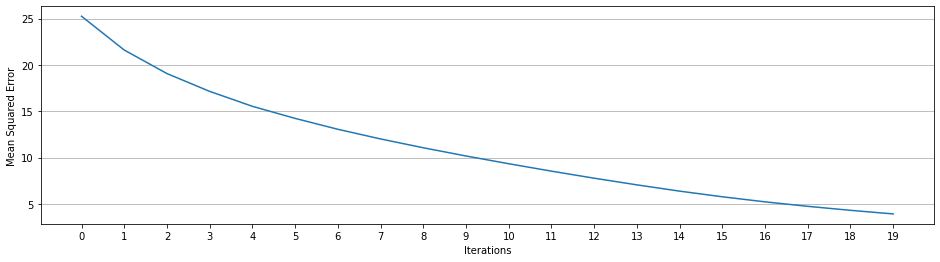

In [73]:
# Training Process를 그래프로 확인해보자

x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=(16,4))
plt.plot(x,y)
plt.xticks(x, x)
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.grid(axis = 'y')